In [1]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#0-died
#1-survived

In [3]:
train = pd.read_csv('train.csv',sep=',')
test = pd.read_csv('test.csv',sep=',')

passenger_ids = test['PassengerId']

In [4]:
#quick data visualization
#sns.pairplot(data=train,hue='Survived',height=2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
#plt.gcf().set_size_inches(15,12)

In [5]:
train_data = train.drop(['Survived'],axis=1)
target = train['Survived']

#FEATURE ENGINEERING

def get_deck(cabin):
    if(pd.isnull(cabin) or cabin[0] == 'T'):
        return np.nan
    else:
        return cabin[0]

def checkChild(age):
    if(age <= 12):
        return 'child'
    elif(12 < age <= 17):
        return 'teenager'
    elif(age > 60):
        return 'senior'
    else:
        return 'adult'

def is_alone(passenger):
    if(passenger['SibSp'] == 0 and passenger['Parch'] == 0):
        return 1
    return 0

def get_prefix(name):
    first_part = name.split(',')[1]
    return first_part[1:].split(' ')[0][:-1]

In [6]:
sex_dict = {'male': 0, 'female': 1}
embark_dict = {'C': 0, 'Q': 1, 'S': 2}
age_dict = {'child': 0,'teenager': 1,'adult': 2, 'senior': 3}

#A,B represent upper decks (i.e. first class cabins)
#C,D,E are the mid decks
#F,G,U are lower decks
deck_dict = {'A':0,'B':0,'C':1,'D':1,'E':1,'F':2,'G':2,'U':2}

prefix_dict = {
    "Mr" :         "Mr",
    "Capt":        "Mr",
    "Col":         "Mr",
    "Major":       "Mr",
    "Dr":          "Mr",
    "Rev":         "Mr",
    "Jonkheer":    "Mr",
    "Don":         "Mr",
    "Sir" :        "Mr",
    "Mme":         "Mrs",
    "Mrs" :        "Mrs",
    "Countess":    "Mrs",
    "Dona":        "Mrs",
    "Lady" :       "Mrs",
    "Master" :     "Master", 
    "Ms":          "Miss",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
}

def create_features(data):

    data['Deck'] = data['Cabin'].apply(get_deck)
    data['Age Group'] = data['Age'].apply(checkChild)
    data['Alone'] = data[['SibSp','Parch']].apply(is_alone,axis=1)
    data['Prefix'] = data['Name'].apply(get_prefix)
    
    data['Prefix'] = data['Prefix'].map(prefix_dict)
    return data

train_data = create_features(train_data)
test = create_features(test)

prefix_group = train_data.groupby(by='Prefix').mean()
pclass_group = train_data.groupby(by='Pclass').mean()

In [7]:
def get_null_fares(passenger):
    if(pd.isnull(passenger['Fare'])):
        return pclass_group.loc[passenger['Pclass']]['Fare']
    return passenger['Fare']

def get_null_ages(passenger):
    if(pd.isnull(passenger['Age'])):
        return prefix_group.loc[passenger['Prefix']]['Age']
    return passenger['Age']

def clean_data(data): #removing any null values
    
    data['Embarked'].fillna('S',inplace=True) #fill empty embarkments with most common port (southampton)
    data['Deck'].fillna('U',inplace=True) #U stands for unknown value
    
    data['Age'] = data[['Age','Prefix']].apply(get_null_ages,axis=1)
    data['Fare'] = data[['Fare','Pclass']].apply(get_null_fares,axis=1)
                                                  
    #feature vectorization
    data['Deck'] = data['Deck'].map(deck_dict)
    data['Sex'] = data['Sex'].map(sex_dict)
    data['Embarked'] = data['Embarked'].map(embark_dict)
    data['Age Group'] = data['Age Group'].map(age_dict)
    
    #removing unnecessary columns
    data.drop(['Cabin','PassengerId','Name','Ticket','Age','Prefix'],axis=1,inplace=True)
    return data

train_data = clean_data(train_data)
test = clean_data(test)

In [8]:
print(train_data['Embarked'].value_counts(),test['Embarked'].value_counts())

2    646
0    168
1     77
Name: Embarked, dtype: int64 2    270
0    102
1     46
Name: Embarked, dtype: int64


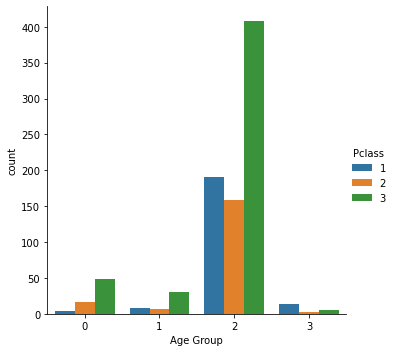

In [9]:
#More data visualization
sns.catplot(x='Age Group',data=train_data, kind='count',hue='Pclass')

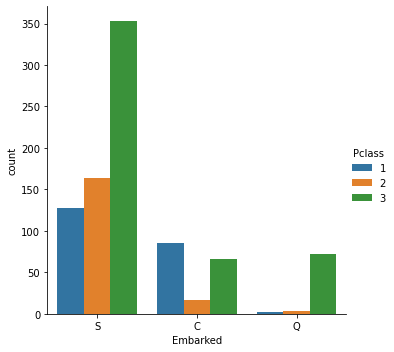

In [10]:
sns.catplot(x='Embarked',kind='count',data=train,hue='Pclass')
#large amount of passengers came from Southampton

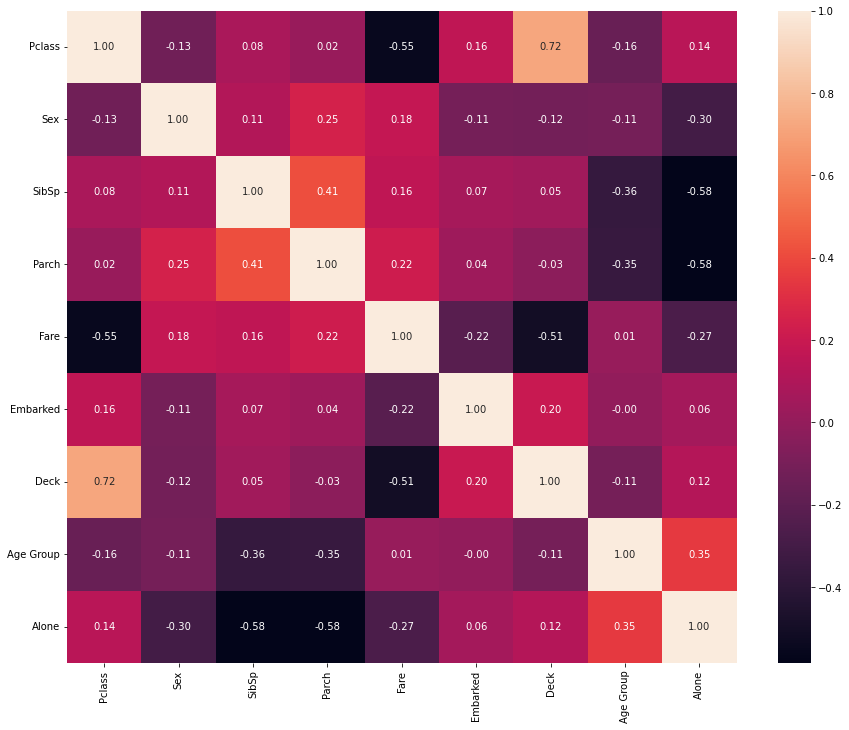

In [11]:
sns.heatmap(train_data.corr(),annot=True,fmt='.2f')
plt.gcf().set_size_inches(15,12)

In [12]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test = scaler.fit_transform(test)

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

classifier_rf = RandomForestClassifier()

#testing our model by first splitting the training set
x_train, x_test, y_train, y_test = train_test_split(train_data,target)
classifier_rf.fit(x_train,y_train)
predictions = classifier_rf.predict(x_test)

from sklearn import metrics
print(metrics.accuracy_score(predictions,y_test))

0.7757847533632287


In [14]:
#Confusion matrix
metrics.confusion_matrix(predictions,y_test)

array([[114,  33],
       [ 17,  59]], dtype=int64)

In [15]:
#default parameters
print(classifier_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [16]:
#Hyperparameter tuning

n_estimators = [x for x in range(50,300,20)]
max_depth = [x for x in range(10,110,10)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]
max_features = ['sqrt','log2',None]

tuning_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'bootstrap': bootstrap}

In [17]:
rand_rf = RandomizedSearchCV(estimator=classifier_rf,param_distributions=tuning_grid,n_iter=150,cv=10,n_jobs=-1,verbose=2)

In [18]:
rand_rf.fit(x_train,y_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 70, 90, 110, 130,
                                                         150, 170, 190, 210,
                                                         230, 250, 270, 290]},
                   verbose=2)

In [19]:
rand_rf.best_params_

{'n_estimators': 170,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 80,
 'bootstrap': False}

In [20]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    accuracy = 100 * metrics.accuracy_score(predictions,test_labels)
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(metrics.accuracy_score(predictions,test_labels)))
    
    return accuracy

#Testing best parameters against base parameters
base_param = RandomForestClassifier()
base_param.fit(x_train,y_train)
evaluate(base_param, x_test, y_test)

Model Performance
Average Error: 0.2197 degrees.
Accuracy = 0.78%.


78.02690582959642

In [21]:
#Best parameters
best_param = rand_rf.best_estimator_
evaluate(best_param, x_test, y_test)

Model Performance
Average Error: 0.2063 degrees.
Accuracy = 0.79%.


79.37219730941703

In [22]:
#Further tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

tuning_grid_2 = {'n_estimators': [rand_rf.best_params_['n_estimators'] + x for x in range(-60,61,20) if x != 0],
               'max_depth': [rand_rf.best_params_['max_depth'] + x for x in range(-10,11,5) if x != 0],
               'min_samples_split': [2,5],
               'min_samples_leaf': [2,4],
               'max_features': [None],
               'bootstrap': [True]}

print(tuning_grid_2)

tmp_classifier = RandomForestClassifier()
gridsearch_rf = GridSearchCV(estimator=tmp_classifier,param_grid=tuning_grid_2,cv=10,n_jobs=-1,verbose=2)

{'n_estimators': [110, 130, 150, 190, 210, 230], 'max_depth': [70, 75, 85, 90], 'min_samples_split': [2, 5], 'min_samples_leaf': [2, 4], 'max_features': [None], 'bootstrap': [True]}


In [23]:
gridsearch_rf.fit(x_train,y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [70, 75, 85, 90],
                         'max_features': [None], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [110, 130, 150, 190, 210, 230]},
             verbose=2)

In [24]:
new_best_param = gridsearch_rf.best_estimator_

#compare with previous best, which was created using randomizedsearch
evaluate(best_param, x_test, y_test)

Model Performance
Average Error: 0.2063 degrees.
Accuracy = 0.79%.


79.37219730941703

In [25]:
evaluate(new_best_param, x_test, y_test)

Model Performance
Average Error: 0.2018 degrees.
Accuracy = 0.80%.


79.82062780269058

In [26]:
#This function returns a dataset formatted to kaggle submission specifications
def get_results(predictions):
    return pd.DataFrame({'PassengerId':passenger_ids.values,'Survived':predictions})

In [27]:
#Test model on real test set
new_best_param.fit(train_data,target)
submit_pred = new_best_param.predict(test)

In [28]:
submission_df = get_results(submit_pred)
submission_df.to_csv("results.csv",index=False)